<a href="https://colab.research.google.com/github/ritiksharmasde/Deep_Learning/blob/main/ORBIT_PREDICTION_LSTM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.5149 - val_loss: 0.9362
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.1633 - val_loss: 0.4496
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1251 - val_loss: 0.2111
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0982 - val_loss: 0.1071
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0865 - val_loss: 0.1074
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0745 - val_loss: 0.0787
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0687 - val_loss: 0.1048
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0585 - val_loss: 0.0791
Epoch 9/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0536 - val_loss: 0.0768
Epoch 10/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0528 - val_loss: 0.0756
Epoch 11/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0439 - val_loss: 0.0793
Epoch 12/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

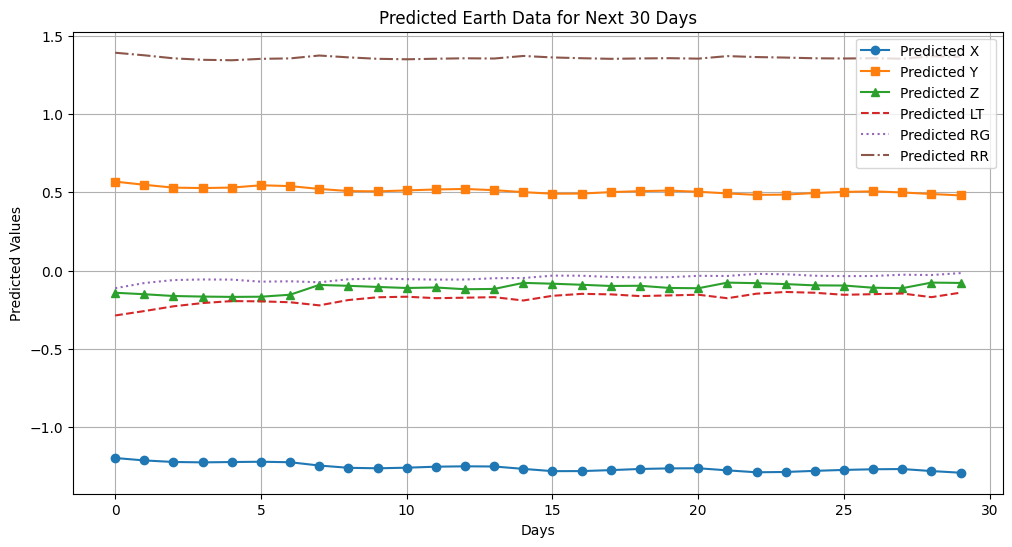

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# 📌 Step 1: Load Data
file_path = "zscore_normalized.csv"
df = pd.read_csv(file_path)

# 📌 Step 2: Select Features & Targets
features = [
    'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'LT', 'RG', 'RR',
    'Semi-major axis', 'Eccentricity', 'Inclination', 'Longitude of Ascending Node',
    'Argument of Periapsis', 'True Anomaly', 'Distance_from_Sun (r)',
    'Specific_Angular_Momentum', 'Specific Orbital Energy '
]

target = ['X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'LT', 'RG', 'RR']  # Predicting these

# Normalize the data
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

sequence_length = 7
X_data, y_data = [], []

# Create sequences
for i in range(len(df_scaled) - sequence_length):
    X_data.append(df_scaled[features].iloc[i:i+sequence_length].values)
    y_data.append(df_scaled[target].iloc[i+sequence_length].values)

X_data, y_data = np.array(X_data), np.array(y_data)

# 📌 Step 3: Train-Test Split (80-20)
split_idx = int(len(X_data) * 0.8)
X_train, X_test = X_data[:split_idx], X_data[split_idx:]
y_train, y_test = y_data[:split_idx], y_data[split_idx:]

# 📌 Step 4: Build LSTM Model
model = Sequential([
    LSTM(256, activation='relu', return_sequences=True, input_shape=(sequence_length, len(features))),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(128, activation='relu', return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(64, activation='relu', return_sequences=False),
    Dense(32, activation='relu'),
    Dense(len(target))  # Predicting X, Y, Z, VX, VY, VZ, LT, RG, RR
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Add Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train Model
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test),
                    callbacks=[early_stop], verbose=1)

# 📌 Step 5: Predict Future Values (Next 30 Days)
future_X = X_test[-1].reshape(1, sequence_length, len(features))
future_predictions = []

for _ in range(30):
    pred = model.predict(future_X)[0]
    future_predictions.append(pred)

    future_X = np.roll(future_X, -1, axis=1)
    future_X[0, -1, :len(target)] = pred  # Correctly update last step

# Convert predictions to DataFrame
pred_df = pd.DataFrame(future_predictions, columns=['Pred_X', 'Pred_Y', 'Pred_Z', 'Pred_VX', 'Pred_VY', 'Pred_VZ', 'Pred_LT', 'Pred_RG', 'Pred_RR'])
pred_df.to_csv('Earth_Next_30Days_Predictions.csv', index=False)

# 📌 Step 6: Save the Model
model.save('LSTM_Earth_Model.h5')

# 📌 Step 7: Download CSV & Model (Colab or Local)
try:
    from google.colab import files
    files.download('Earth_Next_30Days_Predictions.csv')
    files.download('LSTM_Earth_Model.h5')
except ImportError:
    shutil.move("Earth_Next_30Days_Predictions.csv", os.path.expanduser("~/Downloads/"))
    shutil.move("LSTM_Earth_Model.h5", os.path.expanduser("~/Downloads/"))

# 📌 Step 8: Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(pred_df['Pred_X'], label='Predicted X', marker='o')
plt.plot(pred_df['Pred_Y'], label='Predicted Y', marker='s')
plt.plot(pred_df['Pred_Z'], label='Predicted Z', marker='^')
plt.plot(pred_df['Pred_LT'], label='Predicted LT', linestyle='dashed')
plt.plot(pred_df['Pred_RG'], label='Predicted RG', linestyle='dotted')
plt.plot(pred_df['Pred_RR'], label='Predicted RR', linestyle='dashdot')
plt.legend()
plt.title('Predicted Earth Data for Next 30 Days')
plt.xlabel('Days')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import files  # Needed for Colab downloads

# Step 1: Make Predictions on the Test Set
y_pred = model.predict(X_test)

# Step 2: Convert Predictions Back to Original Scale (if scaling was used)
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 6))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 6))

# Step 3: Compute Evaluation Metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

# Step 4: Print Accuracy Results
print(f"📊 Model Evaluation Metrics:")
print(f"🔹 Mean Absolute Error (MAE): {mae:.4f}")
print(f"🔹 Mean Squared Error (MSE): {mse:.4f}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"🔹 R² Score: {r2:.4f}")

# Step 5: Save Predictions to CSV
df_results = pd.DataFrame({
    'Actual_X': y_test_original[:, 0], 'Predicted_X': y_pred_original[:, 0],
    'Actual_Y': y_test_original[:, 1], 'Predicted_Y': y_pred_original[:, 1],
    'Actual_Z': y_test_original[:, 2], 'Predicted_Z': y_pred_original[:, 2],
    'Actual_VX': y_test_original[:, 3], 'Predicted_VX': y_pred_original[:, 3],
    'Actual_VY': y_test_original[:, 4], 'Predicted_VY': y_pred_original[:, 4],
    'Actual_VZ': y_test_original[:, 5], 'Predicted_VZ': y_pred_original[:, 5]
})

df_results.to_csv('Predictions.csv', index=False)

# Step 6: Download CSV
if 'google.colab' in str(get_ipython()):
    files.download('Predictions.csv')  # For Google Colab
else:
    import shutil
    import os
    shutil.move("Predictions.csv", os.path.expanduser("~/Downloads/"))  # For local execution


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


ValueError: cannot reshape array of size 2637 into shape (6)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.5532 - val_loss: 0.8622
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.1757 - val_loss: 0.4066
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.1267 - val_loss: 0.2006
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.1065 - val_loss: 0.1237
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0949 - val_loss: 0.0855
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0796 - val_loss: 0.1001
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0666 - val_loss: 0.1146
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0666 - val_loss: 0.0963
Epoch 9/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0524 - val_loss: 0.0683
Epoch 10/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0509 - val_loss: 0.0856
Epoch 11/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0444 - val_loss: 0.0693
Epoch 12/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/ste

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
📊 Model Evaluation Metrics:
🔹 Mean Absolute Error (MAE): 0.1872
🔹 Mean Squared Error (MSE): 0.0568
🔹 Root Mean Squared Error (RMSE): 0.2384
🔹 R² Score: 0.9526


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

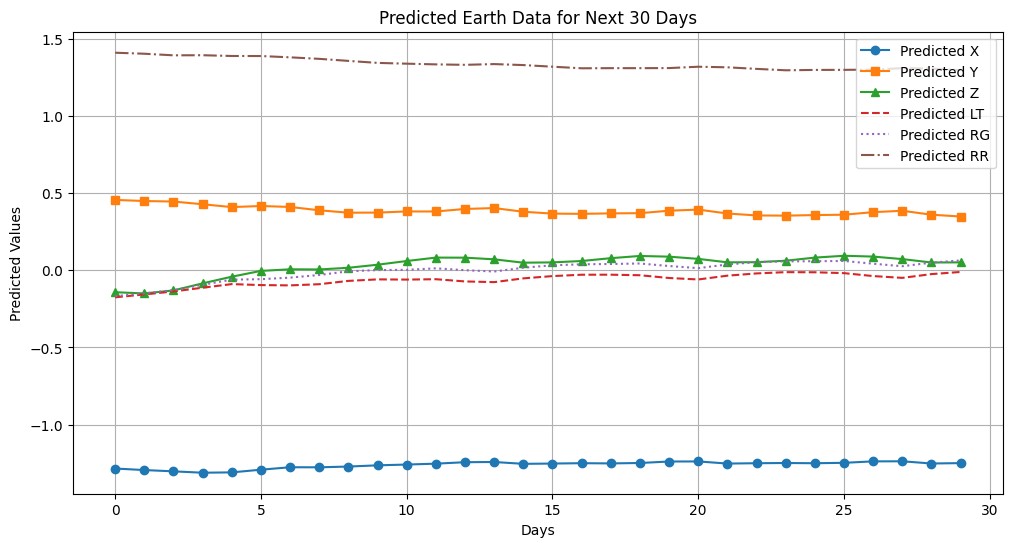

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 📌 Step 1: Load Data
file_path = "zscore_normalized.csv"
df = pd.read_csv(file_path)

# 📌 Step 2: Select Features & Targets
features = [
    'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'LT', 'RG', 'RR',
    'Semi-major axis', 'Eccentricity', 'Inclination', 'Longitude of Ascending Node',
    'Argument of Periapsis', 'True Anomaly', 'Distance_from_Sun (r)',
    'Specific_Angular_Momentum', 'Specific Orbital Energy '
]

target = ['X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'LT', 'RG', 'RR']  # Predicting these

# Normalize the data
# scaler = StandardScaler()
df_scaled = df.copy()
# df_scaled[features] = scaler.fit_transform(df[features])

sequence_length = 7
X_data, y_data = [], []

# Create sequences
for i in range(len(df_scaled) - sequence_length):
    X_data.append(df_scaled[features].iloc[i:i+sequence_length].values)
    y_data.append(df_scaled[target].iloc[i+sequence_length].values)

X_data, y_data = np.array(X_data), np.array(y_data)

# 📌 Step 3: Train-Test Split (80-20)
split_idx = int(len(X_data) * 0.8)
X_train, X_test = X_data[:split_idx], X_data[split_idx:]
y_train, y_test = y_data[:split_idx], y_data[split_idx:]

# 📌 Step 4: Build LSTM Model
model = Sequential([
    LSTM(256, activation='relu', return_sequences=True, input_shape=(sequence_length, len(features))),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(128, activation='relu', return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(64, activation='relu', return_sequences=False),
    Dense(32, activation='relu'),
    Dense(len(target))  # Predicting X, Y, Z, VX, VY, VZ, LT, RG, RR
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Add Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train Model
history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_test, y_test),
                    callbacks=[early_stop], verbose=1)

# 📌 Step 5: Predict Future Values (Next 30 Days)
future_X = X_test[-1].reshape(1, sequence_length, len(features))
future_predictions = []

for _ in range(30):
    pred = model.predict(future_X)[0]
    future_predictions.append(pred)

    future_X = np.roll(future_X, -1, axis=1)
    future_X[0, -1, :len(target)] = pred  # Update last step

# Convert predictions to DataFrame
pred_df = pd.DataFrame(future_predictions, columns=['Pred_X', 'Pred_Y', 'Pred_Z', 'Pred_VX', 'Pred_VY', 'Pred_VZ', 'Pred_LT', 'Pred_RG', 'Pred_RR'])
pred_df.to_csv('Earth_Next_30Days_Predictions.csv', index=False)

# 📌 Step 6: Save the Model
model.save('LSTM_Earth_Model.h5')

# 📌 Step 7: Evaluate Model Accuracy
y_pred = model.predict(X_test)

# Convert Predictions Back to Original Scale
y_pred_original = y_pred
y_test_original = y_test

# Compute Metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

# Print Accuracy Results
print(f"📊 Model Evaluation Metrics:")
print(f"🔹 Mean Absolute Error (MAE): {mae:.4f}")
print(f"🔹 Mean Squared Error (MSE): {mse:.4f}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"🔹 R² Score: {r2:.4f}")

# 📌 Step 8: Save Test Predictions to CSV
df_results = pd.DataFrame()
for i, col in enumerate(target):
    df_results[f'Actual_{col}'] = y_test_original[:, i]
    df_results[f'Predicted_{col}'] = y_pred_original[:, i]

df_results.to_csv('Predictions.csv', index=False)

# 📌 Step 9: Download Files (Colab or Local)
try:
    from google.colab import files
    files.download('Earth_Next_30Days_Predictions.csv')
    files.download('Predictions.csv')
    files.download('LSTM_Earth_Model.h5')
except ImportError:
    shutil.move("Earth_Next_30Days_Predictions.csv", os.path.expanduser("~/Downloads/"))
    shutil.move("Predictions.csv", os.path.expanduser("~/Downloads/"))
    shutil.move("LSTM_Earth_Model.h5", os.path.expanduser("~/Downloads/"))

# 📌 Step 10: Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(pred_df['Pred_X'], label='Predicted X', marker='o')
plt.plot(pred_df['Pred_Y'], label='Predicted Y', marker='s')
plt.plot(pred_df['Pred_Z'], label='Predicted Z', marker='^')
plt.plot(pred_df['Pred_LT'], label='Predicted LT', linestyle='dashed')
plt.plot(pred_df['Pred_RG'], label='Predicted RG', linestyle='dotted')
plt.plot(pred_df['Pred_RR'], label='Predicted RR', linestyle='dashdot')
plt.legend()
plt.title('Predicted Earth Data for Next 30 Days')
plt.xlabel('Days')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()


✅ Z-score reversed: Data is back to original scale!


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


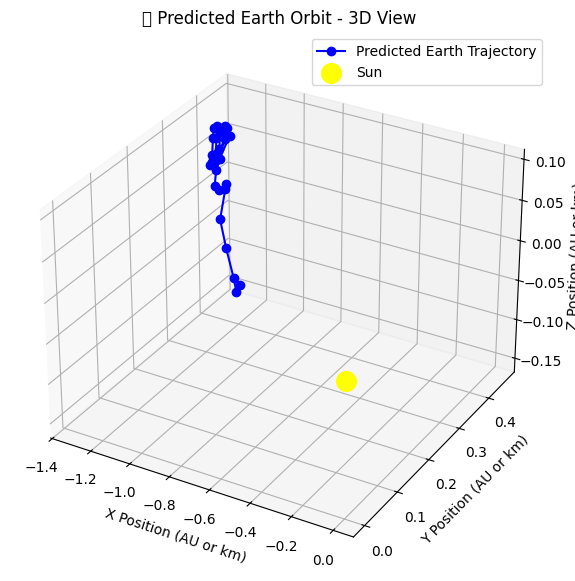

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 📌 Load the predicted positions (Make sure the CSV is generated from previous steps)
pred_df = pd.read_csv("Earth_Next_30Days_Predictions.csv")

# 📌 Reverse Z-score transformation for consistency
y_mean = np.array(y_mean).reshape(1, -1)  # Ensure correct shape
y_std = np.array(y_std).reshape(1, -1)    # Ensure correct shape

y_pred = np.array(y_pred)
y_test = np.array(y_test)

# Ensure dimensions match
if y_pred.shape[1] != y_mean.shape[1]:
    raise ValueError(f"Shape mismatch: y_pred has {y_pred.shape[1]} features, but mean/std have {y_mean.shape[1]}.")

# ✅ Convert Predictions Back to Original Scale
y_pred_original = (y_pred * y_std) + y_mean
y_test_original = (y_test * y_std) + y_mean

print("✅ Z-score reversed: Data is back to original scale!")

# 📌 Extract X, Y, Z coordinates for visualization
x_pred = pred_df["Pred_X"]
y_pred = pred_df["Pred_Y"]
z_pred = pred_df["Pred_Z"]

# 📌 Set up a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 📌 Plot the Earth's predicted orbit
ax.plot(x_pred, y_pred, z_pred, marker='o', linestyle='-', color='b', label="Predicted Earth Trajectory")

# 📌 Mark the Sun at the center (0,0,0)
ax.scatter(0, 0, 0, color='yellow', marker='o', s=200, label="Sun")

# 📌 Labels & Title
ax.set_xlabel("X Position (AU or km)")
ax.set_ylabel("Y Position (AU or km)")
ax.set_zlabel("Z Position (AU or km)")
ax.set_title("🌍 Predicted Earth Orbit - 3D View")

# 📌 Legend & Grid
ax.legend()
ax.grid()

# 📌 Show the 3D plot
plt.show()
